In [1]:
!git clone https://github.com/AvonYangXX1/DreamWalker.git

Cloning into 'DreamWalker'...
remote: Enumerating objects: 495, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 495 (delta 21), reused 135 (delta 17), pack-reused 353
Receiving objects: 100% (495/495), 1.39 GiB | 16.06 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Updating files: 100% (128/128), done.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import time
from IPython import display

In [3]:
def Laplacian_smoothing(amp, sigma=1e-8):
    amp += sigma
    return amp / np.sum(amp, axis=2, keepdims=True)

In [4]:
path = "DreamWalker/data/processed_data/AMP"
pep = np.load(f"{path}/pep_whole.npz")["data"].astype("float32")
label = np.load(f"{path}/label_whole.npz")["data"].astype("float32")
pep = tf.one_hot(pep, depth=43).numpy()
amp = pep[np.where(label <= 0.89)]
amp = Laplacian_smoothing(amp, sigma=1e-8)
amp = np.log(amp)
# Replace to GAN Data Later

In [6]:
def linear_schedule(time_steps, beta_start=0.0001, beta_end=0.02):
    betas = np.linspace(beta_start, beta_end, time_steps)
    alpha_t = 1.0 - betas
    alpha_cumprod_t = np.cumprod(alpha_t)
    return alpha_cumprod_t

def add_noise(x, t, alpha_cumprod_t):
    noise = np.random.normal(size=x.shape)
    new_x = np.sqrt(alpha_cumprod_t) * x + np.sqrt(1 - alpha_cumprod_t) * noise
    return new_x, noise

def prepare_data(pep, time_steps, n_steps_needed):
    alphas_cumprod = linear_schedule(time_steps)
    prob = n_steps_needed / (time_steps * pep.shape[0])
    sampled_steps = {
        "x": [],
        "t": [],
        "noise": []
    }
    for i in range(pep.shape[0]):
        x = pep[i]
        for t in range(time_steps):
            x, noise = add_noise(x, t, alphas_cumprod[t])
            if np.random.random() < prob:
                sampled_steps['x'].append([x])
                sampled_steps['noise'].append([noise])
                time_vector = np.zeros(time_steps)
                time_vector[t] = 1
                sampled_steps['t'].append([time_vector])

    sampled_steps['noise'] = np.concatenate(sampled_steps['noise'], axis=0)
    sampled_steps['x'] = np.concatenate(sampled_steps['x'], axis=0)
    sampled_steps['t'] = np.concatenate(sampled_steps['t'], axis=0)
    p = np.arange(sampled_steps['t'].shape[0])
    np.random.shuffle(p)
    sampled_steps['t'] = sampled_steps['t'][p]
    sampled_steps['x'] = sampled_steps['x'][p]
    sampled_steps['noise'] = sampled_steps['noise'][p]
    return sampled_steps

In [7]:
time_steps = 1000
n_steps_needed = 50000

In [8]:
sampled_steps = prepare_data(amp[0:100], time_steps, n_steps_needed)

In [9]:
def conv_block(input_tensor, num_filters):
    x = tf.keras.layers.Conv1D(num_filters, 3, padding="same")(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv1D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = tf.keras.layers.MaxPooling1D(2)(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    x = tf.keras.layers.Conv1DTranspose(num_filters, 2, strides=2, padding="same")(input_tensor)
    x = tf.keras.layers.concatenate([x, concat_tensor], axis=1)
    x = conv_block(x, num_filters)
    return x

def build_unet_model(time_steps, pep_shape=(40, 43)):
    pep_inputs = tf.keras.layers.Input(shape=pep_shape)
    time_inputs = tf.keras.layers.Input(shape=(time_steps,))
    time_embedding = tf.keras.layers.Dense(40*43, activation='tanh')(time_inputs)
    time_embedding = tf.keras.layers.Reshape((40, 43))(time_embedding)
    inputs = tf.keras.layers.Add()([pep_inputs, time_embedding])

    # Encoder

    x1, p1 = encoder_block(inputs, 64)
    x2, p2 = encoder_block(p1, 128)
    x3, p3 = encoder_block(p2, 256)
    x4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b, x4, 512)
    d2 = decoder_block(d1, x3, 256)
    d3 = decoder_block(d2, x2, 128)
    d4 = decoder_block(d3, x1, 64)

    # Output
    outputs = tf.keras.layers.Conv1D(3, 1, padding="same", activation="sigmoid")(d4)
    outputs = tf.keras.layers.Flatten()(outputs)
    outputs = tf.keras.layers.Dense(40*43)(outputs)
    outputs = tf.keras.layers.Reshape((40, 43))(outputs)

    model = tf.keras.models.Model([pep_inputs, time_inputs], outputs, name="U-Net")
    return model


In [10]:
unet = build_unet_model(time_steps=time_steps)
unet.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
unet.fit([sampled_steps['x'], sampled_steps['t']], sampled_steps['noise'], epochs=10)

Epoch 1/10
1567/1567 [==============================] - 57s 24ms/step - loss: 0.9962
Epoch 2/10
1567/1567 [==============================] - 36s 23ms/step - loss: 0.9540
Epoch 3/10
1567/1567 [==============================] - 37s 24ms/step - loss: 0.9363
Epoch 4/10
1567/1567 [==============================] - 37s 23ms/step - loss: 0.9270
Epoch 5/10
1567/1567 [==============================] - 38s 24ms/step - loss: 0.9187
Epoch 6/10
1567/1567 [==============================] - 39s 25ms/step - loss: 0.9120
Epoch 7/10
1567/1567 [==============================] - 37s 23ms/step - loss: 0.9050
Epoch 8/10
1567/1567 [==============================] - 37s 23ms/step - loss: 0.8986
Epoch 9/10
1567/1567 [==============================] - 37s 23ms/step - loss: 0.8944
Epoch 10/10
1567/1567 [==============================] - 36s 23ms/step - loss: 0.8917


In [12]:
def denoise_step(x, noise, t, alpha_cumprod):
    old_x = ( x -  noise * np.sqrt(1 - alpha_cumprod) ) / np.sqrt(alpha_cumprod)
    return old_x

def generate(x, model, alpha_cumprod_t, time_steps, start_step=-1, end_step=999):
    log = [[x]]
    for i in range(end_step, start_step, -1):
        time_embedding = np.zeros(time_steps)
        time_embedding[i] = 1
        time_embedding = np.repeat([time_embedding], x.shape[0], axis=0)
        noise = model.predict([x, time_embedding], verbose=0)
        x = denoise_step(x, noise, i, alpha_cumprod_t[i])
        log.append([x])
    return np.concatenate(log, axis=0)

In [21]:
alpha_cumprod = linear_schedule(time_steps)
x = np.random.normal(size=(10, 40, 43))
log = generate(x, unet, alpha_cumprod, time_steps, start_step=149, end_step=199)

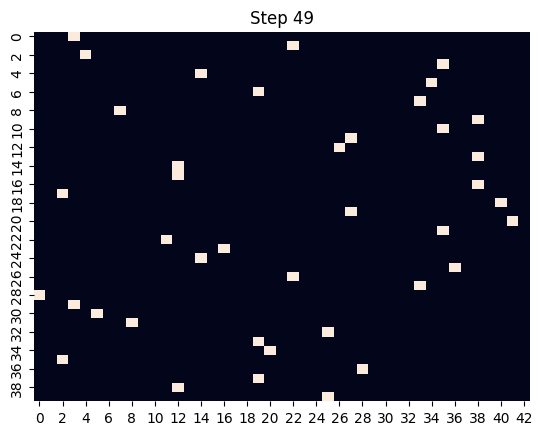

In [22]:
for t in range(50):
    tmp = log[t][0]
    tmp = np.exp(tmp)
    tmp = tmp / np.sum(tmp, axis=1, keepdims=True)
    sns.heatmap(tmp, cbar=False)
    plt.title(f"Step {t}")
    display.display(plt.gcf())
    time.sleep(0.1)
    display.clear_output(wait=True)